<a href="https://colab.research.google.com/github/qiujun4417/social-media-analysis/blob/main/%E7%A4%BE%E4%BA%A4%E5%AA%92%E4%BD%93%E6%83%85%E6%84%9F%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/
!ls

/content/drive/My Drive/Colab Notebooks
社交媒体情感分析.ipynb


In [3]:
!pip install tensorflow
!pip install transformers
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.4 MB/s eta 0:00:00


In [4]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are {} GPU(s) available', torch.cuda.device_count())
else:
  device = torch.device("cpu")
  print('There are no GPU available')

There are {} GPU(s) available 1


In [5]:
hidden_dropout_prob = 0.3
num_labels = 2
learning_rate = 1e-5
weight_decay = 1e-2
epochs = 8
batch_size = 16
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import torch.nn as nn
from transformers import AdamW
from torch.utils.data import Dataset
import pandas as pd
import torch
from transformers import BertConfig, BertForSequenceClassification
from transformers import BertTokenizer
from torch.utils.data import DataLoader


# 定义 Dataset
class SentimentDataset(Dataset):
    def __init__(self, path_to_file):
        self.dataset = pd.read_csv(path_to_file, sep="\t", names=["text", "label"])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # 根据 idx 分别找到 text 和 label
        text = self.dataset.loc[idx, "text"]
        label = self.dataset.loc[idx, "label"]
        sample = {"text": text, "label": label}
        # 返回一个 dict
        return sample


In [7]:
sentiment_train_set = SentimentDataset("./data/sentiment.train.data")
sentiment_train_loader = DataLoader(sentiment_train_set, batch_size=batch_size, shuffle=True, num_workers=0)

# 加载验证集
sentiment_valid_set = SentimentDataset("./data/sentiment.valid.data")
sentiment_valid_loader = DataLoader(sentiment_valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [8]:
# 定义 tokenizer，传入词汇表
model_name = 'hfl/chinese-bert-wwm'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

Some weights of the model checkpoint at hfl/chinese-bert-wwm were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [9]:
# 定义优化器和损失函数
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

#optimizer = AdamW(model.parameters(), lr=learning_rate)
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
# 定义训练的函数
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for i, batch in enumerate(dataloader):
        # 标签形状为 (batch_size, 1)
        label = batch["label"].to(device)
        text = batch["text"]

        # tokenized_text 包括 input_ids， token_type_ids， attention_mask
        tokenized_text = tokenizer(text, max_length=100, add_special_tokens=True, truncation=True, padding=True, return_tensors="pt")
        tokenized_text = tokenized_text.to(device)
        # 梯度清零
        optimizer.zero_grad()

        #output: (loss), logits, (hidden_states), (attentions)
        output = model(**tokenized_text, labels=label)

        # y_pred_prob = logits : [batch_size, num_labels]
        y_pred_prob = output[1]
        y_pred_label = y_pred_prob.argmax(dim=1)

        # 计算loss
        # 这个 loss 和 output[0] 是一样的
        loss = criterion(y_pred_prob.view(-1, 2), label.view(-1))

        # 计算acc
        acc = ((y_pred_label == label.view(-1)).sum()).item()

        # 反向传播
        loss.backward()
        optimizer.step()

        # epoch 中的 loss 和 acc 累加
        # loss 每次是一个 batch 的平均 loss
        epoch_loss += loss.item()
        # acc 是一个 batch 的 acc 总和
        epoch_acc += acc
        if i % 200 == 0:
            print("current loss:", epoch_loss / (i+1), "\t", "current acc:", epoch_acc / ((i+1)*len(label)))

    # len(dataloader) 表示有多少个 batch，len(dataloader.dataset.dataset) 表示样本数量
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader.dataset.dataset)

def evaluate(model, iterator, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    with torch.no_grad():
        for _, batch in enumerate(iterator):
            label = batch["label"].to(device)
            text = batch["text"]
            tokenized_text = tokenizer(text, max_length=170, add_special_tokens=True, truncation=True, padding=True,
                                       return_tensors="pt")
            tokenized_text = tokenized_text.to(device)

            output = model(**tokenized_text, labels=label)
            y_pred_label = output[1].argmax(dim=1)
            loss = output[0]
            acc = ((y_pred_label == label.view(-1)).sum()).item()
            # epoch 中的 loss 和 acc 累加
            # loss 每次是一个 batch 的平均 loss
            epoch_loss += loss.item()
            # acc 是一个 batch 的 acc 总和
            epoch_acc += acc

    # len(dataloader) 表示有多少个 batch，len(dataloader.dataset.dataset) 表示样本数量
    return epoch_loss / len(iterator), epoch_acc / len(iterator.dataset.dataset)

current loss: 0.6648954153060913 	 current acc: 0.5625
current loss: 0.3333358773729991 	 current acc: 0.8669154228855721
current loss: 0.28808076168292035 	 current acc: 0.8873129675810474
current loss: 0.26583524744728343 	 current acc: 0.8971505823627288
current loss: 0.25298089842392263 	 current acc: 0.9032459425717853
current loss: 0.2398972232676261 	 current acc: 0.9089035964035964
train loss:  0.23785371788320153 	 train acc: 0.9097333570877131
valid loss:  0.16989030983919898 	 valid acc: 0.9341544291804832
current loss: 0.1967322677373886 	 current acc: 0.875
current loss: 0.13400678677178585 	 current acc: 0.957089552238806
current loss: 0.1349465775528825 	 current acc: 0.9523067331670823
current loss: 0.1315477277894509 	 current acc: 0.9529950083194676
current loss: 0.126171692150102 	 current acc: 0.9556023720349563
current loss: 0.12149103426073979 	 current acc: 0.9566683316683317
train loss:  0.12160416883491652 	 train acc: 0.9567670289209573
valid loss:  0.13905572

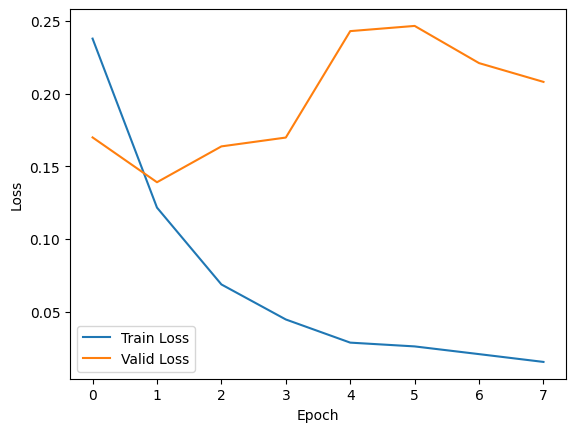

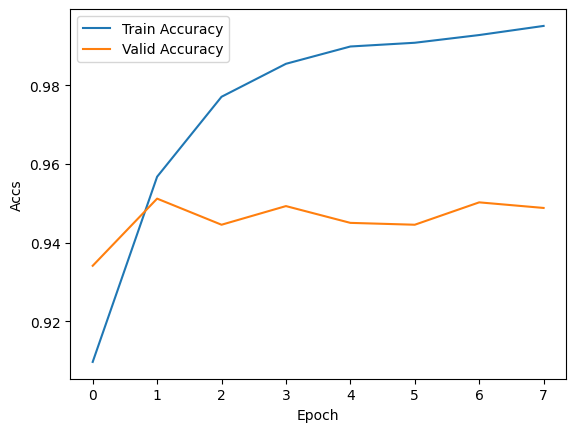

In [11]:
import matplotlib.pyplot as plt

# 开始训练和验证
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for i in range(epochs):
    train_loss, train_acc = train(model, sentiment_train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print("train loss: ", train_loss, "\t", "train acc:", train_acc)
    valid_loss, valid_acc = evaluate(model, sentiment_valid_loader, device)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    print("valid loss: ", valid_loss, "\t", "valid acc:", valid_acc)


# 绘制损失函数曲线
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制准确度曲线
plt.plot(train_accs, label='Train Accuracy')
plt.plot(valid_accs, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accs')
plt.legend()
plt.show()

In [12]:
def evaluate_validate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["text"]
            labels = batch["label"].to(device)
            # tokenized_inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors="pt")
            tokenized_inputs = tokenizer(inputs, padding='max_length', truncation=True, max_length=512, return_tensors="pt")

            tokenized_inputs = {key: value.to(device) for key, value in tokenized_inputs.items()}

            outputs = model(**tokenized_inputs)
            predicted_labels = torch.argmax(outputs.logits, dim=1)

            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()

    accuracy = correct / total
    return accuracy

sentiment_test_set = SentimentDataset("./data/sentiment.test.data")
sentiment_test_loader = DataLoader(sentiment_valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

accuracy = evaluate_validate(model, sentiment_test_loader, device)
print("Validation Accuracy: {:.2f}%".format(accuracy * 100))

Validation Accuracy: 94.69%


In [21]:
data = pd.read_csv('./data/comments_data.csv')

# 选择content和comment_at字段，并创建一个新的DataFrame
df = data[['content', 'comment_time']].copy()
# 将comment_at字段转换为日期时间类型
df['comment_time'] = pd.to_datetime(df['comment_time'])
df['content'] = df['content'].astype(str)
df = df.dropna()

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20694 entries, 0 to 20693
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   content       20694 non-null  object        
 1   comment_time  20694 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 323.5+ KB


,content,comment_time
0,你还记得你自己说过的话吗,2023-07-03 11:39:17
1,总结真怀孕 真流产 我想继续赚钱,2023-07-03 11:32:23
2,谁允许你谈恋爱的 我恨你,2023-07-03 11:35:17
3,需要憋五天才来个回应吗,2023-07-03 11:33:11
4,那就是跟的怀孕流产了呗困,2023-07-03 11:31:56


In [22]:
for index, row in df.iterrows():
    content = row['content']
    content_str = str(content)
    encoded_text = tokenizer.encode_plus(content_str, add_special_tokens=True, truncation=True, padding='max_length', max_length=170, return_tensors='pt')
    input_ids = encoded_text['input_ids']
    attention_mask = encoded_text['attention_mask']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # 使用Bert模型进行分类预测
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_label = torch.argmax(outputs.logits, dim=1).item()

    # 将预测的标签添加到DataFrame的label字段
    df.loc[index, 'label'] = predicted_label

<ipython-input-22-1098bb6cc7fe>:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  for index, row in df.iterrows():


In [24]:
# 对DataFrame按照comment_time字段进行排序，并可视化情感随时间的变化：
df.info()

df.head(50)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20694 entries, 0 to 20693
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   content       20694 non-null  object        
 1   comment_time  20694 non-null  datetime64[ns]
 2   label         20694 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 485.1+ KB


,content,comment_time,label
0,你还记得你自己说过的话吗,2023-07-03 11:39:17,1.0
1,总结真怀孕 真流产 我想继续赚钱,2023-07-03 11:32:23,0.0
2,谁允许你谈恋爱的 我恨你,2023-07-03 11:35:17,0.0
3,需要憋五天才来个回应吗,2023-07-03 11:33:11,0.0
4,那就是跟的怀孕流产了呗困,2023-07-03 11:31:56,0.0
5,天哪 哑巴终于会说话了 httptcnA6pd1XYZ,2023-07-03 11:32:21,0.0
6,好的 会继续支持你演唱会 httptcnA6pd1MKW,2023-07-03 11:30:55,1.0
7,为什么不早点出来回应因为今天是周一拜拜拜拜拜拜,2023-07-03 11:32:10,0.0
8,所以爱豆谈恋爱不带套让女方打胎是真的了呗,2023-07-03 11:32:42,0.0
9,额粉丝让我大开眼界哆啦A梦害怕哆啦A梦害怕哆啦A梦害怕哆啦A梦害怕,2023-07-03 11:39:38,1.0


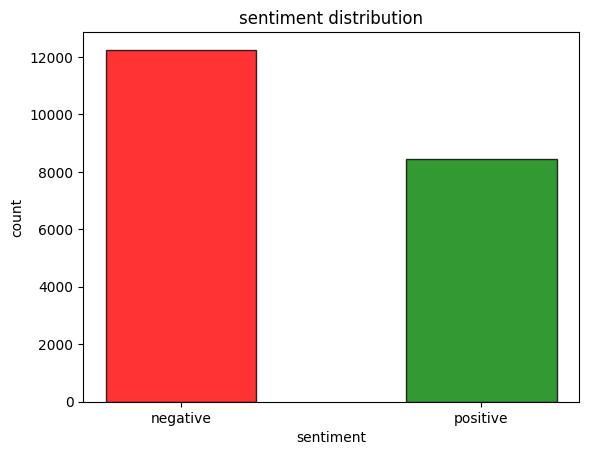

In [26]:
# 对DataFrame按照comment_time字段进行排序，并可视化情感随时间的变化：
df_sorted = df.sort_values('comment_time')

# 提取评论时间和情感标签
comment_time = df_sorted['comment_time']
label = df_sorted['label']

# 统计每个情感标签的数量
sentiment_counts = label.value_counts()

# 创建柱状图
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'green'], edgecolor='black', width=0.5, alpha=0.8)
plt.xlabel('sentiment')
plt.ylabel('count')
plt.title('sentiment distribution')
plt.xticks(sentiment_counts.index, ['negative', 'positive'])  # 将标签0和1替换为可读的标签
plt.show()

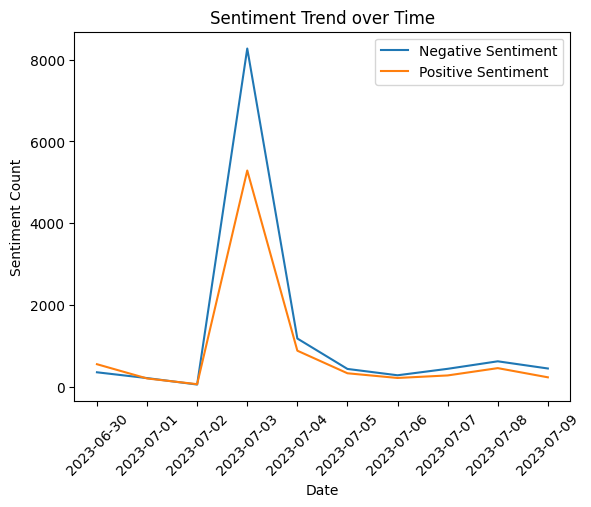

In [30]:
# 统计每天的情绪数量
sentiment_counts = df_sorted.groupby(df['comment_time'].dt.date)['label'].value_counts().unstack().fillna(0)


# sentiment_labels = df_sorted['label'].replace({0: 'negative', 1: 'positive'})

dates = sentiment_counts.index
negative_counts = sentiment_counts[0]
positive_counts = sentiment_counts[1]

# 绘制折线图
plt.plot(dates, negative_counts, label='Negative Sentiment')
plt.plot(dates, positive_counts, label='Positive Sentiment')

# 添加图例、标题和轴标签
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.title('Sentiment Trend over Time')

# 旋转x轴标签以便更易读
plt.xticks(rotation=45)

# 显示图形
plt.show()

In [31]:
df.to_csv('./data/comment_sentiment_data.csv', index=False, encoding='utf-8-sig')